# Analyse Exploratoire

A réaliser : 
- Une analyse descriptive des données, y compris une explication du sens des colonnes gardées, des arguments derrière la suppression de lignes ou de colonnes, des statistiques descriptives et des visualisations pertinentes.

### Import des modules

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [86]:
bc_csv = pd.read_csv("data/2016_Building_Energy_Benchmarking.csv")
print(f"Dataset initial : {len(bc_csv)} bâtiments, {bc_csv.shape[1]} colonnes")

Dataset initial : 3376 bâtiments, 46 colonnes


In [87]:
# On regarde comment un batiment est défini dans ce jeu de données 
bc_csv.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Variables identifiées par catégories :  
- Identification :  
    OSEBuildingID, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber
- Géolocalisation :   
    Latitude, Longitude, Neighborhood, CouncilDistrictCode  
- Caractéristiques physiques :   
    YearBuilt, NumberofFloors, NumberofBuildings,PropertyGFATotal, PropertyGFABuilding(s),PropertyGFAParking, LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA
- Usage :   
    BuildingType, PrimaryPropertyType, ListOfAllPropertyUseTypes, LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType
- Performance énergétique :   
    YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), ComplianceStatus, Outlier
- Consommation :   
    DataYear, SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), Electricity(kWh) , Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), SteamUse(kBtu)  
- Émissions :   
    TotalGHGEmissions, GHGEmissionsIntensity 

## Traitements des outliers déclarés

In [88]:
mask = bc_csv['Outlier'].notna()
bc_csv[mask]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,2016,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.0,0942000045,...,1.166315e+07,39794668.0,16048.309570,1604831.0,False,NaN,Non-Compliant,High outlier,362.66,2.10
384,539,2016,NonResidential,Retail Store,University Center,4501 Roosevelt Way NE,Seattle,WA,98105.0,5335200380,...,9.348260e+04,318963.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,2.22,0.03
448,608,2016,NonResidential,Large Office,411 1ST AVE S (ID608),411 1ST AVE S,Seattle,WA,98104.0,5247800200,...,4.715030e+05,1608768.0,3430.500488,343050.0,False,NaN,Non-Compliant,Low outlier,29.43,0.19
517,704,2016,NonResidential,Large Office,401 Elliott Ave West,401 Elliot Ave West,Seattle,WA,98119.0,7666202110,...,7.953454e+06,27137187.0,0.000000,0.0,False,NaN,Non-Compliant,High outlier,189.18,1.46
720,19708,2016,Multifamily HR (10+),High-Rise Multifamily,Bay Vista,2821 2nd Ave,Seattle,WA,98121.0,0586400000,...,6.265616e+05,2137828.0,2700.760010,270076.0,False,NaN,Non-Compliant,Low outlier,29.25,0.17
834,19934,2016,Multifamily LR (1-4),Low-Rise Multifamily,Belmont Lofts,231 Belmont Ave E,Seattle,WA,98102.0,0704600000,...,7.502090e+04,255971.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,1.78,0.06
839,19967,2016,SPS-District K-12,K-12 School,Queen Anne Gym,1431 2nd Ave N,Seattle,WA,98109.0,0811000005,...,7.228240e+04,246628.0,1848.439575,184844.0,True,NaN,Error - Correct Default Data,Low outlier,11.54,0.32
962,20367,2016,Multifamily LR (1-4),Low-Rise Multifamily,City Lights on Harbor,2349 Harbor Ave. SW,Seattle,WA,98126.0,1595200000,...,2.058855e+05,702481.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,4.90,0.07
1045,20617,2016,NonResidential,Retail Store,Seattle Habitat Store,21 S Nevada St,Seattle,WA,98134.0,1824049074,...,1.436250e+04,49005.0,964.640015,96464.0,True,NaN,Error - Correct Default Data,Low outlier,5.46,0.14
1229,21315,2016,NonResidential,Small- and Mid-Sized Office,1518 Fifith Ave,1520 Fifth Ave,Seattle,WA,98101.0,1975700135,...,7.064900e+03,24105.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,0.17,0.00


In [89]:
# Tous sont non-compliant concernant la conformité aux normes de relevés énergétiques - Nous les éliminons
bc_without_outliers = bc_csv[~mask].copy()
print(f"Après filtrage des outliers déclarés : {len(bc_csv)} → {len(bc_without_outliers)} bâtiments")

Après filtrage des outliers déclarés : 3376 → 3344 bâtiments


## Traitement des valeurs candidates

In [90]:
# choix de SiteEnergyUse(kBtu) comme valeur target
target_cols = ['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',  'Electricity(kBtu)',  'NaturalGas(kBtu)', 'SteamUse(kBtu)']
bc_with_candidates = bc_without_outliers.dropna(subset=target_cols, how='all').copy()
print(f"Après filtrage targets vides: {len(bc_without_outliers)} → {len(bc_with_candidates)} bâtiments")
bc_with_candidates[target_cols].info()

Après filtrage targets vides: 3344 → 3339 bâtiments
<class 'pandas.core.frame.DataFrame'>
Index: 3339 entries, 0 to 3375
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SiteEnergyUse(kBtu)    3339 non-null   float64
 1   SiteEnergyUseWN(kBtu)  3338 non-null   float64
 2   Electricity(kBtu)      3335 non-null   float64
 3   NaturalGas(kBtu)       3335 non-null   float64
 4   SteamUse(kBtu)         3335 non-null   float64
dtypes: float64(5)
memory usage: 156.5 KB


In [92]:
# Exclusions des valeurs en unités non standards : Electricity(kWh), NaturalGas(therms),
bc_with_candidates[['Electricity(kBtu)',  'NaturalGas(kBtu)', 'SteamUse(kBtu)']].fillna(0)
# vérification 
bc_with_candidates['AllUses']= bc_with_candidates[['Electricity(kBtu)',  'NaturalGas(kBtu)', 'SteamUse(kBtu)']].sum(axis=1)
mask = (bc_with_candidates['SiteEnergyUse(kBtu)'].isna()) | (bc_with_candidates['SiteEnergyUse(kBtu)']==0)
bc_with_candidates.loc[mask,'SiteEnergyUse(kBtu)'] = bc_with_candidates.loc[mask, 'AllUses']
mask = (bc_with_candidates['SiteEnergyUse(kBtu)'].isna()) | (bc_with_candidates['SiteEnergyUse(kBtu)']==0)
bc_with_candidates.loc[mask,'SiteEnergyUse(kBtu)'] = bc_with_candidates.loc[mask, 'SiteEnergyUseWN(kBtu)']
mask = (bc_with_candidates['SiteEnergyUse(kBtu)'].isna()) | (bc_with_candidates['SiteEnergyUse(kBtu)']==0)
bc_with_target = bc_with_candidates[~mask].copy()
print(f"Après filtrage targets nuls: {len(bc_with_candidates)} → {len(bc_with_target)} bâtiments")


Après filtrage targets nuls: 3339 → 3332 bâtiments


<Axes: xlabel='AllUses', ylabel='SiteEnergyUse(kBtu)'>

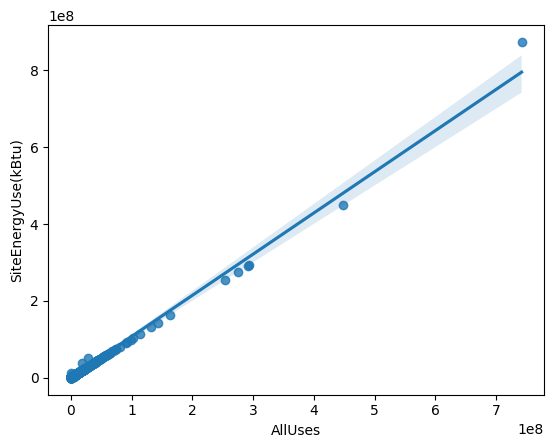

In [94]:


sns.regplot(bc_with_target, x='AllUses', y='SiteEnergyUse(kBtu)')

Valeur Candidate retenue : SiteEnergyUse(kBtu)
## Traitement des usages
### Affichage des usages utilisés

In [226]:
bc_with_target[['BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3332 entries, 0 to 3375
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   BuildingType                  3332 non-null   object
 1   PrimaryPropertyType           3332 non-null   object
 2   ListOfAllPropertyUseTypes     3332 non-null   object
 3   LargestPropertyUseType        3332 non-null   object
 4   SecondLargestPropertyUseType  1661 non-null   object
 5   ThirdLargestPropertyUseType   589 non-null    object
dtypes: object(6)
memory usage: 182.2+ KB


In [95]:
use_types = []
for i,row in bc_with_target.iterrows():
    if not pd.isna(row['ListOfAllPropertyUseTypes']):
        for use in row['ListOfAllPropertyUseTypes'].split(','):
            use =  use.strip()
            if use not in use_types:
                use_types.append(use)
                print(use)
del use_types

Hotel
Parking
Restaurant
Swimming Pool
Police Station
Other - Entertainment/Public Assembly
Multifamily Housing
Data Center
Library
Fitness Center/Health Club/Gym
Office
Other
Other - Lodging/Residential
Social/Meeting Hall
Courthouse
K-12 School
College/University
Automobile Dealership
Retail Store
Self-Storage Facility
Energy/Power Station
Laboratory
Manufacturing/Industrial Plant
Non-Refrigerated Warehouse
Refrigerated Warehouse
Other - Education
Vocational School
Other - Mall
Personal Services (Health/Beauty
Dry Cleaning
etc)
Senior Care Community
Medical Office
Distribution Center
Hospital (General Medical & Surgical)
Museum
Repair Services (Vehicle
Shoe
Locksmith
Food Service
Residence Hall/Dormitory
Other - Services
Other/Specialty Hospital
Financial Office
Other - Utility
Fast Food Restaurant
Movie Theater
Supermarket/Grocery Store
Worship Facility
Lifestyle Center
Other - Recreation
Convenience Store without Gas Station
Pre-school/Daycare
Food Sales
Other - Restaurant/Bar
Sing

### Vérification de l'usage principal d'habitation

In [96]:
# Let's check property without largest use type
mask = bc_with_target['LargestPropertyUseType'].isna()
bc_with_target[mask][['ListOfAllPropertyUseTypes','BuildingType','PrimaryPropertyType','LargestPropertyUseType']]

,ListOfAllPropertyUseTypes,BuildingType,PrimaryPropertyType,LargestPropertyUseType
353,"Fitness Center/Health Club/Gym, Office, Other ...",NonResidential,Self-Storage Facility,NaN
1077,Multifamily Housing,Multifamily HR (10+),High-Rise Multifamily,NaN
1147,Hotel,NonResidential,Hotel,NaN
1483,Multifamily Housing,Multifamily MR (5-9),Mid-Rise Multifamily,NaN
1756,Multifamily Housing,Multifamily HR (10+),High-Rise Multifamily,NaN
1768,NaN,Multifamily LR (1-4),Low-Rise Multifamily,NaN
2321,NaN,Multifamily LR (1-4),Low-Rise Multifamily,NaN
2336,Multifamily Housing,Multifamily LR (1-4),Low-Rise Multifamily,NaN
2414,Office,NonResidential,Small- and Mid-Sized Office,NaN
2459,Restaurant,NonResidential,Restaurant,NaN


### Correction manuelle des valeurs manquantes

In [97]:
mask = bc_with_target['LargestPropertyUseType'].isna() & bc_with_target['PrimaryPropertyType'].str.contains('Multifamily')
bc_with_target.loc[mask,'LargestPropertyUseType']= "Multifamily Housing"
mask = bc_with_target['LargestPropertyUseType'].isna() 
bc_with_target[mask][['ListOfAllPropertyUseTypes','BuildingType','PrimaryPropertyType','LargestPropertyUseType']]
bc_with_target.loc[mask,'LargestPropertyUseType']= bc_with_target.loc[mask,'PrimaryPropertyType']
mask = bc_with_target['ListOfAllPropertyUseTypes'].isna() 
bc_with_target.loc[mask,'ListOfAllPropertyUseTypes']= bc_with_target.loc[mask,'LargestPropertyUseType']



### Exclusion des propriétés à usage principal d'habitation (non temporaire)

In [129]:
exclude_first_use = ["Multifamily Housing", "Single Family Home","Residence Hall/Dormitory","Other - Lodging/Residential"]
mask = bc_with_target["LargestPropertyUseType"].isin( exclude_first_use)
bc_only_non_residential = bc_with_target[~mask].copy()
print(f"Après filtrage des types de propriétés : {len(bc_with_target)} → {len(bc_only_non_residential)} bâtiments")


Après filtrage des types de propriétés : 3332 → 1641 bâtiments


In [130]:
bc_only_non_residential['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office    289
Other                          244
Warehouse                      187
Large Office                   170
K-12 School                    134
Mixed Use Property             106
Retail Store                    89
Hotel                           76
Worship Facility                69
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: count, dtype: int64

In [227]:
bc_only_non_residential['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  492
Non-Refrigerated Warehouse                              199
K-12 School                                             134
Other                                                    98
Retail Store                                             97
Hotel                                                    77
Worship Facility                                         69
Distribution Center                                      54
Senior Care Community                                    46
Medical Office                                           41
Supermarket/Grocery Store                                41
Parking                                                  32
Other - Recreation                                       31
Self-Storage Facility                                    29
College/University                                       25
Other - Entertainment/Public Assembly                    21
Restaurant       

In [232]:
mask = (bc_only_non_residential['PrimaryPropertyType'].str.contains('Other')) &  (~ bc_only_non_residential['LargestPropertyUseType'].str.contains('Other'))
bc_only_non_residential[mask][['PrimaryPropertyType', 'LargestPropertyUseType']]
bc_only_non_residential['CorrectUseType'] = bc_only_non_residential['PrimaryPropertyType']
bc_only_non_residential.loc[mask,'CorrectUseType'] = bc_only_non_residential.loc[mask,'LargestPropertyUseType']

In [233]:
bc_only_non_residential['CorrectUseType'].value_counts()

CorrectUseType
Small- and Mid-Sized Office                             289
Warehouse                                               187
Large Office                                            170
Other                                                   154
K-12 School                                             134
Mixed Use Property                                      106
Retail Store                                             89
Hotel                                                    76
Worship Facility                                         69
Distribution Center                                      53
Senior Care Community                                    45
Supermarket / Grocery Store                              40
Medical Office                                           39
Self-Storage Facility                                    28
University                                               25
Parking                                                  17
Restaurant               

## Traitement des caractéristiques physiques
### Traitement des surfaces

In [132]:
phy_cols = ['PropertyGFATotal', 'PropertyGFABuilding(s)','PropertyGFAParking', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
bc_only_non_residential[phy_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1641 entries, 0 to 3375
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PropertyGFATotal                 1641 non-null   int64  
 1   PropertyGFABuilding(s)           1641 non-null   int64  
 2   PropertyGFAParking               1641 non-null   int64  
 3   LargestPropertyUseTypeGFA        1637 non-null   float64
 4   SecondLargestPropertyUseTypeGFA  850 non-null    float64
 5   ThirdLargestPropertyUseTypeGFA   344 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 89.7 KB


In [133]:
# 'YearBuilt', 'NumberofFloors', 'NumberofBuildings'
bc_only_non_residential[phy_cols].fillna(0)
bc_only_non_residential['3LargestGFA']= bc_only_non_residential[['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']].sum(axis=1)
mask = bc_only_non_residential['3LargestGFA']==0
bc_only_non_residential.loc[mask, '3LargestGFA']= bc_only_non_residential.loc[mask, 'PropertyGFATotal']
corr_values = ['SiteEnergyUse(kBtu)', 'PropertyGFATotal', 'PropertyGFABuilding(s)','PropertyGFAParking', 'LargestPropertyUseTypeGFA','3LargestGFA']
bc_only_non_residential[corr_values].corr()

,SiteEnergyUse(kBtu),PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,3LargestGFA
SiteEnergyUse(kBtu),1.000000,0.809844,0.826476,0.144106,0.845250,0.857504
PropertyGFATotal,0.809844,1.000000,0.990217,0.379024,0.978485,0.982624
PropertyGFABuilding(s),0.826476,0.990217,1.000000,0.246190,0.983148,0.977360
PropertyGFAParking,0.144106,0.379024,0.246190,1.000000,0.276385,0.343594
LargestPropertyUseTypeGFA,0.845250,0.978485,0.983148,0.276385,1.000000,0.981608
3LargestGFA,0.857504,0.982624,0.977360,0.343594,0.981608,1.000000


In [135]:
bc_only_non_residential['3LargestGFA'].describe()

count    1.641000e+03
mean     1.219627e+05
std      3.059045e+05
min      8.223000e+03
25%      3.017200e+04
50%      5.075900e+04
75%      1.055630e+05
max      9.320156e+06
Name: 3LargestGFA, dtype: float64

<Axes: xlabel='3LargestGFA', ylabel='SiteEnergyUse(kBtu)'>

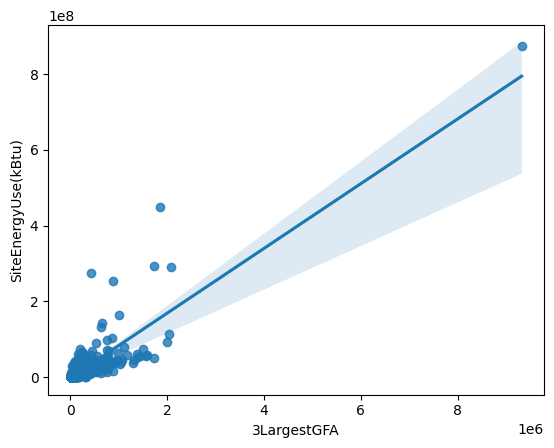

In [136]:
# Choix de 3LargestGFA comme predicteur surface
sns.regplot(bc_only_non_residential, x='3LargestGFA', y= 'SiteEnergyUse(kBtu)')

#### Traitement des outliers de performances

count    1641.000000
mean       68.531288
std        69.916386
min         1.430046
25%        31.667928
50%        47.763631
75%        76.995014
max       834.402500
Name: CalcEUI, dtype: float64


<Axes: xlabel='CalcEUI'>

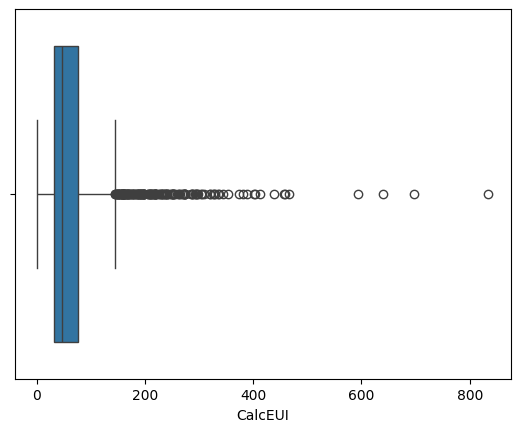

In [216]:
bc_only_non_residential['CalcEUI'] = bc_only_non_residential['SiteEnergyUse(kBtu)'] / bc_only_non_residential['3LargestGFA']
print(bc_only_non_residential['CalcEUI'].describe())
sns.boxplot(bc_only_non_residential,x = 'CalcEUI')

In [225]:
mask = (bc_only_non_residential['CalcEUI'] < 5) | (bc_only_non_residential['CalcEUI']>400)
bc_only_non_residential[mask][['CalcEUI', 'PrimaryPropertyType', 'LargestPropertyUseType', 'YearBuilt','Neighborhood', 'PropertyGFATotal','LargestPropertyUseTypeGFA','3LargestGFA','ComplianceStatus']].sort_values('CalcEUI')

,CalcEUI,PrimaryPropertyType,LargestPropertyUseType,YearBuilt,Neighborhood,PropertyGFATotal,LargestPropertyUseTypeGFA,3LargestGFA,ComplianceStatus
1577,1.430046,Self-Storage Facility,Self-Storage Facility,1915,MAGNOLIA / QUEEN ANNE,39952,39952.0,39952.0,Compliant
595,2.115986,Distribution Center,Distribution Center,1969,GREATER DUWAMISH,71718,71718.0,71718.0,Compliant
2246,2.304459,Distribution Center,Distribution Center,1952,GREATER DUWAMISH,16300,65164.0,65164.0,Compliant
974,3.018623,Warehouse,Non-Refrigerated Warehouse,1900,DOWNTOWN,33300,24000.0,30000.0,Compliant
1576,3.152422,Self-Storage Facility,Self-Storage Facility,1980,MAGNOLIA / QUEEN ANNE,30989,30989.0,30989.0,Compliant
380,3.346921,Self-Storage Facility,Self-Storage Facility,1988,MAGNOLIA / QUEEN ANNE,130293,130293.0,139093.0,Compliant
3009,3.459713,Warehouse,Non-Refrigerated Warehouse,1920,EAST,23040,23040.0,23040.0,Compliant
609,3.529496,Warehouse,Non-Refrigerated Warehouse,1966,DELRIDGE,170632,164806.0,170632.0,Compliant
378,3.598461,Warehouse,Non-Refrigerated Warehouse,1941,BALLARD,63240,63240.0,63240.0,Compliant
1658,3.826589,Self-Storage Facility,Self-Storage Facility,1977,NORTH,33344,31360.0,32344.0,Compliant


#### Traitement de l'année de construction

In [137]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
phy_cols = ['YearBuilt', 'NumberofFloors', 'NumberofBuildings']
bc_only_non_residential[phy_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1641 entries, 0 to 3375
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   YearBuilt          1641 non-null   int64  
 1   NumberofFloors     1641 non-null   int64  
 2   NumberofBuildings  1641 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 51.3 KB


In [139]:
mask = (bc_only_non_residential['YearBuilt'] < 1800) | (bc_only_non_residential['YearBuilt'] > 2016)
bc_only_non_residential[mask][phy_cols]


,YearBuilt,NumberofFloors,NumberofBuildings


In [140]:
mask = (bc_only_non_residential['NumberofBuildings'] < 1) 
bc_only_non_residential[mask][phy_cols]

,YearBuilt,NumberofFloors,NumberofBuildings
63,1965,3,0.0
76,1986,2,0.0
160,1916,4,0.0
201,1968,3,0.0
241,1961,5,0.0
264,1970,1,0.0
278,1926,10,0.0
280,1973,19,0.0
291,1996,4,0.0
358,1955,1,0.0


In [141]:
bc_only_non_residential.loc[mask,'NumberofBuildings']=1
mask = (bc_only_non_residential['NumberofFloors'] < 1) 
bc_only_non_residential[mask][phy_cols]

,YearBuilt,NumberofFloors,NumberofBuildings
166,1999,0,1.0
487,2004,0,1.0
488,2006,0,1.0
564,1999,0,1.0
1754,1945,0,1.0
1993,1991,0,10.0
3130,1940,0,1.0
3131,1960,0,1.0
3132,1960,0,1.0
3168,1929,0,8.0


## Traitement des variables de Géolocalisation :   
    Latitude, Longitude, Neighborhood, CouncilDistrictCode 

In [142]:
geo_col = ['Latitude', 'Longitude', 'Neighborhood', 'CouncilDistrictCode'] 
bc_only_non_residential[geo_col].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1641 entries, 0 to 3375
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Latitude             1641 non-null   float64
 1   Longitude            1641 non-null   float64
 2   Neighborhood         1641 non-null   object 
 3   CouncilDistrictCode  1641 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 64.1+ KB


<Axes: ylabel='Longitude'>

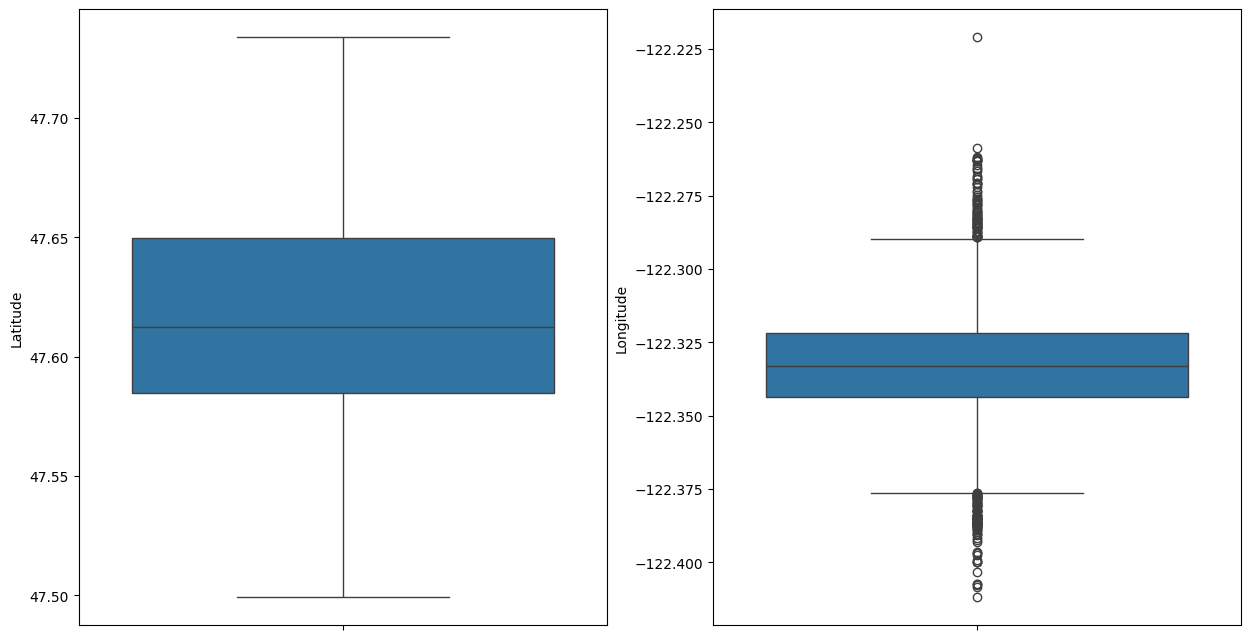

In [143]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
sns.boxplot(bc_only_non_residential['Latitude'], ax=ax[0])
sns.boxplot(bc_only_non_residential['Longitude'], ax=ax[1])


In [144]:
bc_only_non_residential['Neighborhood'] = bc_only_non_residential['Neighborhood'].str.upper()
bc_only_non_residential['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                  351
GREATER DUWAMISH          342
MAGNOLIA / QUEEN ANNE     150
LAKE UNION                145
EAST                      118
NORTHEAST                 112
NORTHWEST                  90
NORTH                      73
BALLARD                    70
CENTRAL                    54
SOUTHEAST                  47
DELRIDGE                   47
SOUTHWEST                  41
DELRIDGE NEIGHBORHOODS      1
Name: count, dtype: int64

In [145]:
bc_only_non_residential['CouncilDistrictCode'].value_counts()

CouncilDistrictCode
7    519
2    394
3    197
4    155
5    138
1    120
6    118
Name: count, dtype: int64

# Modélisation 

In [293]:
bc_minimal = bc_only_non_residential[['3LargestGFA', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes', 'CorrectUseType', 'YearBuilt', 'NumberofFloors', 'NumberofBuildings','Latitude', 'Longitude', 'Neighborhood',
                                     'SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']].copy()
bc_minimal

,3LargestGFA,PrimaryPropertyType,ListOfAllPropertyUseTypes,CorrectUseType,YearBuilt,NumberofFloors,NumberofBuildings,Latitude,Longitude,Neighborhood,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
0,88434.0,Hotel,Hotel,Hotel,1927,12,1.0,47.61220,-122.33799,DOWNTOWN,7.226362e+06,3.946027e+06,1.276453e+06,2003882.00
1,103566.0,Hotel,"Hotel, Parking, Restaurant",Hotel,1996,11,1.0,47.61317,-122.33393,DOWNTOWN,8.387933e+06,3.242851e+06,5.145082e+06,0.00
2,756493.0,Hotel,Hotel,Hotel,1969,41,1.0,47.61393,-122.33810,DOWNTOWN,7.258702e+07,4.952666e+07,1.493800e+06,21566554.00
3,61320.0,Hotel,Hotel,Hotel,1926,10,1.0,47.61412,-122.33664,DOWNTOWN,6.794584e+06,2.768924e+06,1.811213e+06,2214446.25
4,191454.0,Hotel,"Hotel, Parking, Swimming Pool",Hotel,1980,18,1.0,47.61375,-122.34047,DOWNTOWN,1.417261e+07,5.368607e+06,8.803998e+06,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,12294.0,Office,Office,Office,1990,1,1.0,47.56722,-122.31154,GREATER DUWAMISH,8.497457e+05,5.242709e+05,3.254750e+05,0.00
3372,16000.0,Other,Other - Recreation,Other,2004,1,1.0,47.59625,-122.32283,DOWNTOWN,9.502762e+05,3.965461e+05,5.537300e+05,0.00
3373,13157.0,Other,"Fitness Center/Health Club/Gym, Other - Recrea...",Other,1974,1,1.0,47.63644,-122.35784,MAGNOLIA / QUEEN ANNE,5.765898e+06,1.792159e+06,3.973739e+06,0.00
3374,13586.0,Mixed Use Property,"Fitness Center/Health Club/Gym, Food Service, ...",Mixed Use Property,1989,1,1.0,47.52832,-122.32431,GREATER DUWAMISH,7.194712e+05,3.488702e+05,3.706010e+05,0.00


## Import des modules 

In [287]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import r2_score, mean_absolute_error , root_mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


## Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

#### Modes énergétiques

In [294]:
bc_minimal['use_gas'] = (bc_minimal['NaturalGas(kBtu)'].notna()) & (bc_minimal['NaturalGas(kBtu)'] != 0)
bc_minimal['use_steam'] = (bc_minimal['SteamUse(kBtu)'].notna()) & (bc_minimal['SteamUse(kBtu)'] != 0)
bc_minimal['use_electricity'] = (bc_minimal['Electricity(kBtu)'].notna()) & (bc_minimal['Electricity(kBtu)'] != 0)

#### Age de la propriété

count    1641.000000
mean       53.436319
std        32.506356
min         1.000000
25%        27.000000
50%        50.000000
75%        85.000000
max       116.000000
Name: AgeProperty, dtype: float64


<Axes: ylabel='AgeProperty'>

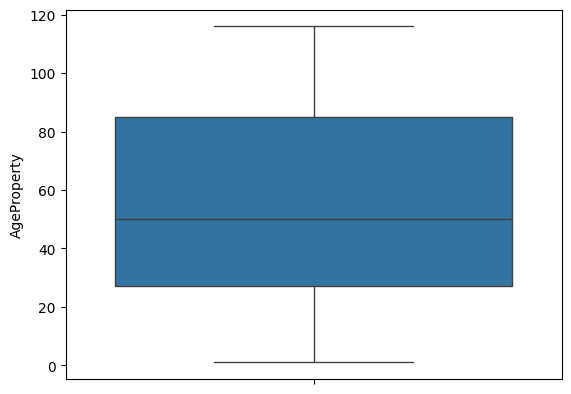

In [295]:

bc_minimal['AgeProperty']= 2016 - bc_minimal['YearBuilt']
print(bc_minimal['AgeProperty'].describe())
sns.boxplot(bc_minimal['AgeProperty'])


#### distance du centre ville

In [296]:
seattle_position = (47.6085965,-122.5049456)
bc_minimal['CityDistance'] = np.sqrt(
    (bc_minimal['Latitude'] - seattle_position[0])**2 + 
    (bc_minimal['Longitude'] - seattle_position[1])**2)
bc_minimal['CityDistance'].describe()


count    1641.000000
mean        0.178664
std         0.026149
min         0.099400
25%         0.164800
50%         0.176047
75%         0.192523
max         0.303815
Name: CityDistance, dtype: float64

<Axes: xlabel='AgeProperty', ylabel='SiteEUI(kBtu/sf)'>

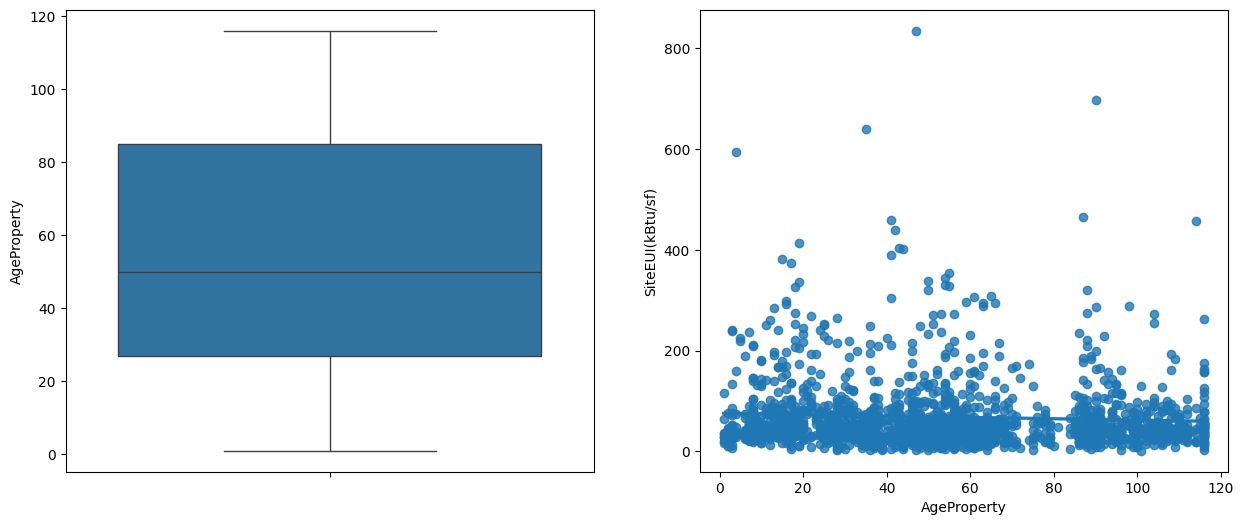

In [297]:
bc_minimal['SiteEUI(kBtu/sf)']= bc_minimal['SiteEnergyUse(kBtu)']/bc_minimal['3LargestGFA']
fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.boxplot(bc_minimal['AgeProperty'],ax=ax[0])
sns.regplot(x=bc_minimal['AgeProperty'], y=bc_minimal['SiteEUI(kBtu/sf)'],ax=ax[1])

#### Utilisation multiple

In [298]:
bc_minimal['MultipleUseType'] = bc_minimal['ListOfAllPropertyUseTypes'].str.count('s')+1
bc_minimal['MultipleUseType'].value_counts()

MultipleUseType
1    971
2    537
3     93
4     32
6      3
7      2
5      2
8      1
Name: count, dtype: int64

In [299]:
bc_minimal.columns

Index(['3LargestGFA', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes',
       'CorrectUseType', 'YearBuilt', 'NumberofFloors', 'NumberofBuildings',
       'Latitude', 'Longitude', 'Neighborhood', 'SiteEnergyUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'use_gas',
       'use_steam', 'use_electricity', 'AgeProperty', 'CityDistance',
       'SiteEUI(kBtu/sf)', 'MultipleUseType'],
      dtype='object')

### Split train/test

In [300]:
predict_values = ['3LargestGFA', 'PrimaryPropertyType', 'MultipleUseType', 'use_steam', 'use_electricity', 'use_gas',
       'AgeProperty', 'NumberofFloors', 'NumberofBuildings', 'CityDistance', 'Neighborhood', 'CorrectUseType']
X = bc_minimal[predict_values]
y = bc_minimal['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [301]:
mask = (X_train['NumberofFloors'] < 1) 
OneBuildingMeanFloor = X_train[X_train['NumberofBuildings']==1]["NumberofFloors"].mean()
OneBuildingMeanFloor = int(OneBuildingMeanFloor.round(0))
X_train.loc[mask,'NumberofFloors'] = OneBuildingMeanFloor
X_train['AvgFloor'] = X_train['NumberofFloors']/X_train['NumberofBuildings']

mask = (X_test['NumberofFloors'] < 1) 
X_test.loc[mask,'NumberofFloors'] = OneBuildingMeanFloor
X_test['AvgFloor'] = X_test['NumberofFloors']/X_test['NumberofBuildings']
OneBuildingMeanFloor

4

In [302]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_vars= ['CorrectUseType', 'Neighborhood']
encoder.fit(X_train[encoded_vars])
X_train_encoded = encoder.transform(X_train[encoded_vars])
columns_encoded = encoder.get_feature_names_out(encoded_vars)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=columns_encoded, index=X_train.index)

X_train_final = pd.concat([X_train, X_train_encoded_df], axis=1)

X_test_encoded = encoder.transform(X_test[encoded_vars])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=columns_encoded, index=X_test.index)
X_test_final = pd.concat([X_test, X_test_encoded_df], axis=1)

In [303]:
X_train_final.drop(columns=['NumberofFloors','NumberofBuildings'],inplace=True)
X_test_final.drop(columns=['NumberofFloors','NumberofBuildings'],inplace=True)
X_test_final.drop(columns='PrimaryPropertyType',inplace=True)
X_train_final.drop(columns='PrimaryPropertyType',inplace=True)
X_test_final.drop(columns=encoded_vars,inplace=True)
X_train_final.drop(columns=encoded_vars,inplace=True)

#### Vérification et normalisation

In [304]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1312 entries, 2338 to 1965
Data columns (total 64 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   3LargestGFA                                                     1312 non-null   float64
 1   MultipleUseType                                                 1312 non-null   int64  
 2   use_steam                                                       1312 non-null   bool   
 3   use_electricity                                                 1312 non-null   bool   
 4   use_gas                                                         1312 non-null   bool   
 5   AgeProperty                                                     1312 non-null   int64  
 6   CityDistance                                                    1312 non-null   float64
 7   AvgFloor                                             

In [305]:
quantitative_cols = [
    col for col in X_train_final.columns 
    if (col not in columns_encoded) and (X_train_final[col].dtype in ['float64', 'int64'])
]
scaler = StandardScaler()
X_train_final[quantitative_cols] = scaler.fit_transform(X_train_final[quantitative_cols])
X_test_final[quantitative_cols] = scaler.transform(X_test_final[quantitative_cols])

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [306]:
# CODE COMPARAISON DES MODELES

models = {
    'DummyRegressor' : DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1)
}
results = {}

for name, model in models.items():
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    results[name] = {
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred)
    }
for m, score in results.items():
    print(m, score)

DummyRegressor {'RMSE': 18475582.000482395, 'R2': -0.007253837610562419, 'MAE': 8171283.858719898, 'MAPE': 4.216861022625012}
LinearRegression {'RMSE': 9163778.069201646, 'R2': 0.7522054214800784, 'MAE': 4497236.202779674, 'MAPE': 1.4787653690355813}
SVR {'RMSE': 19020329.909137435, 'R2': -0.06752674852921325, 'MAE': 5866385.644160349, 'MAPE': 1.0475913198577216}
GradientBoosting {'RMSE': 10046063.740428055, 'R2': 0.7021932525668497, 'MAE': 3544164.95729855, 'MAPE': 0.9320131303348025}
RandomForest {'RMSE': 8594300.258724326, 'R2': 0.7820465641162211, 'MAE': 3339004.45232972, 'MAPE': 0.8307252249062986}


LinearRegression {'RMSE': 9184344.000370981, 'R2': 0.7510919408322276, 'MAE': 4515040.324226945}
SVR {'RMSE': 19020329.9125678, 'R2': -0.0675267489142759, 'MAE': 5866385.710710276}
GradientBoosting {'RMSE': 10190081.740058739, 'R2': 0.6935934745315477, 'MAE': 3626497.4356230735}
RandomForest {'RMSE': 10802078.562154608, 'R2': 0.6556838942808976, 'MAE': 3718321.822001789}

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [308]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# Définir une petite grille d’hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200],          # nombre d’arbres
    'max_depth': [10, 20, None],         # profondeur max des arbres
    'min_samples_split': [2, 5]          # nombre min d’échantillons pour split
}

# Créer et configurer la GridSearch
gs = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE négatif car maximisation par GridSearch
    cv=3,                                  # validation croisée 3 folds pour rapidité
    n_jobs=-1,
    verbose=1
)

# Exécuter la recherche sur le train
gs.fit(X_train_final, y_train)

# Afficher les meilleurs paramètres et score
print("Best parameters:", gs.best_params_)
print("Best RMSE (neg):", gs.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE (neg): -22887717.541033253


In [311]:
best_model = gs.best_estimator_

importances = best_model.feature_importances_
feature_names = X_train_final.columns

# Affichage du top 10 features les plus importantes
sorted_idx = importances.argsort()[::-1]
print("Top 10 features by importance:")
for idx in sorted_idx[:15]:
    print(f"- {feature_names[idx]}: {importances[idx]:.4f}")

Top 10 features by importance:
- 3LargestGFA: 0.4445
- AvgFloor: 0.3473
- CorrectUseType_Hospital: 0.0567
- CityDistance: 0.0317
- CorrectUseType_Data Center: 0.0316
- AgeProperty: 0.0272
- CorrectUseType_Mixed Use Property: 0.0100
- Neighborhood_NORTHEAST: 0.0071
- CorrectUseType_University: 0.0068
- MultipleUseType: 0.0054
- CorrectUseType_Other: 0.0048
- Neighborhood_GREATER DUWAMISH: 0.0046
- use_gas: 0.0036
- CorrectUseType_Laboratory: 0.0029
- use_steam: 0.0017


In [312]:
y_pred = best_model.predict(X_test_final)
rmse = root_mean_squared_error(y_test, y_pred)  
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Recalculated RMSE: {rmse}")
print(f"Recalculated R2: {r2}")
print(f"Recalculated MAE: {mae}")
print(f"Recalculated MAPE: {mape}")

Recalculated RMSE: 8594300.258724326
Recalculated R2: 0.7820465641162211
Recalculated MAE: 3339004.45232972
Recalculated MAPE: 0.8307252249062986


RandomForest {'RMSE': 8594300.258724326, 'R2': 0.7820465641162211, 'MAE': 3339004.45232972, 'MAPE': 0.8307252249062986}
